In [1]:
import os

import numpy as np

import matplotlib.pyplot as plt

import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import QTable
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm

from photutils import SkyCircularAperture, aperture_photometry

from scipy.interpolate import LinearNDInterpolator
from astropy.modeling import models, fitting

from regions import CircleSkyRegion

home = os.path.expanduser('~')

In [2]:
def get_vignetting(instrument,energy,theta,phi,vig_table):
    #
    # get the pre-calculated vignetting factor for input energy, off-axis and azimuth
    #
    # Using scipy.intepolate.NearestNDInterpolator
    #
    # energy is in eV
    # theta is the off-axis angle in arcsec
    # phi is the azimuth angle in degrees
    #
    if (not os.path.isfile(vig_table)):
        print ("File with the pre-calculated vignetting function for energy, off-axis and azimuth not found")
        print ("I am looking for a file here:",vig_table)
        return None
    vtab = QTable.read(vig_table)
    inter = LinearNDInterpolator((vtab['Energy'], vtab['Theta'], vtab['Phi']), vtab['Vig'])
    result = inter(energy,theta,phi)
    return result

In [3]:
def tie_sigmas(model):
    #
    # utility function to use for circular Gaussian2D, to tie sigma_x=sigma_y
    # not used at the moment, just commented out in the fit_source
    #
    return model.x_stddev

In [4]:
def fit_source(image,wcs,region,box=5,plot_it=True,verbose=True):
    #
    # Fit a Gaussian2D on an image with WCS and source region
    #
    qwcs = wcs.deepcopy()
    qwcs.wcs.crpix += 1
    reg_pix = region.to_pixel(qwcs)
    center = reg_pix.center
    xshape = image.shape
    col0 = max(int(center.x - box/2.0),0)
    col1 = min(int(center.x + box/2.0),xshape[0])
    row0 = max(int(center.y - box/2.0),0)
    row1 = min(int(center.y + box/2.0),xshape[1])
    #
    # cut out small sub-image of size [box,box] to use for fitting
    #
    wimage = image[row0:row1,col0:col1]
    wshape = wimage.shape
    if (wshape[0] != box or wshape[1] != box):
        if (verbose):
            print (f'Not performing a fit as the cropped area is not {box}x{box} size (outside image?).')
        return None
    #
    # circular Gaussian (sigma_x = sigma_y)
    #
    #p_init = models.Gaussian2D(amplitude=20.0,x_mean=wshape[0]/2.0,y_mean=wshape[1]/2.0,
    #                           theta=0.0,x_stddev=1.1,y_stddev=1.1,
    #                          bounds={'amplitude': (1,100), 'x_mean': (1.0,box-1.0),'y_mean': (1.0,box-1.0)},
    #                          tied={'y_stddev': tie_sigmas})
    #
    # elliptical Gaussian
    p_init = models.Gaussian2D(amplitude=20.0,x_mean=wshape[0]/2.0,y_mean=wshape[1]/2.0,
                               theta=0.0,x_stddev=1.1,y_stddev=1.1,
                              bounds={'amplitude': (1,100), 'x_mean': (1.0,box-1.0),'y_mean': (1.0,box-1.0)})
    #
    y, x = np.mgrid[:wshape[0], :wshape[1]]
    fit_p = fitting.LevMarLSQFitter()
    p = fit_p(p_init, y, x, wimage)
    #
    if (plot_it):
        # Plot the data with the best-fit model
        plt.figure(figsize=(8, 2.5))
        plt.subplot(1, 3, 1)
        norm = simple_norm(wimage, 'linear')
        plt.imshow(wimage, origin='lower', interpolation='nearest', norm=norm)
        plt.title("Data")
        plt.subplot(1, 3, 2)
        model = p(x,y)
        norm = simple_norm(model, 'linear')
        plt.imshow(model, origin='lower', interpolation='nearest', norm=norm)
        plt.title("Model")
        plt.subplot(1, 3, 3)
        residual = wimage - model
        norm = simple_norm(residual, 'linear')
        plt.imshow(residual, origin='lower', interpolation='nearest', norm=norm)
        plt.title("Residual")
    return p

In [5]:
def measure_counts(image,wcs,region):
    #
    # measure the total counts in an aperture, using photutil aperture_photometry
    #
    xap = SkyCircularAperture(region.center,region.radius)
    photo = aperture_photometry(image, xap, wcs=wcs)
    return photo['aperture_sum'][0]

In [6]:
#
# read the empirical vignetting, we use pn
#
# vtb = f"{home}/Dropbox/Work/XMM/vignetting/pn_vignetting_table.fits"
vtb = f"pn_vignetting_table.fits"
offs = np.linspace(0.0,900.0,20)
xv1 = get_vignetting('pn',500.0,offs,0.0,vtb)
xv2 = get_vignetting('pn',2000.0,offs,0.0,vtb)

In [7]:
wdir = f'/home/sam/Documents/ESA/xmm_simulation/other/vignet_creation'
#fname = f'{wdir}/test_grid_f_1e-13_step_10_1_mult_20_0ks (1).fits'
#fname = f'{wdir}/test_grid_f_1e-13_step_10_2_mult_20_0ks (1).fits'
#fname = f'{wdir}/test_grid_f_1e-13_step_10_4_mult_20_0ks (1).fits'
#fname = f'{wdir}/test_grid_f_1e-13_step_10_1_mult_20_0ks.fits'
#fname = f'{wdir}/test_grid_f_1e-13_step_10_2_mult_20_0ks.fits'
#fname = f'{wdir}/test_grid_f_1e-13_step_10_4_mult_20_0ks.fits'
#
# new files, 09 Jul 2021
#
fname = f'/home/sam/Documents/ESA/data/sim/test_vignet_extend/test_grid_f_1e-13_step_10_4_mult_nobackground_100_0ks.fits'
#fname = f'{wdir}/test_grid_f_1e-13_step_10_1_mult_20_0ks (2).fits'
bname = os.path.basename(fname)
#
with fits.open(fname) as hdu:
    wcs1 = WCS(hdu[0].header)
    image1 = hdu[0].data
#with fits.open(f'{wdir}/2x_res_half_psf_e-13_20_0ks.fits') as hdu:
#    wcs2 = WCS(hdu2[0].header)
#    image2 = hdu[0].data

#src = QTable.read(f'{wdir}/test_grid_f_1e-13_step_10.simput',hdu=1)
src = QTable.read(f'/home/sam/Documents/ESA/data/sim/simput/test_grid/test_grid_f_1e-13_step_10.simput',hdu=1)
#

In [8]:
ra = src['RA']
dec = src['DEC']
flux = src['FLUX']
with open(f'{wdir}/sources.reg','w') as fin:
    print ('fk5',file=fin)
    for j in np.arange(len(src)):
        print (f'circle({ra[j].value:.5f},{dec[j].value:.5f},40")',file=fin)
#

In [9]:
sources = SkyCoord(ra,dec,unit=u.deg,frame='icrs')
reg = []
radius = 20.0*u.arcsec
for j in sources:
    reg.append(CircleSkyRegion(j,radius=radius))
#

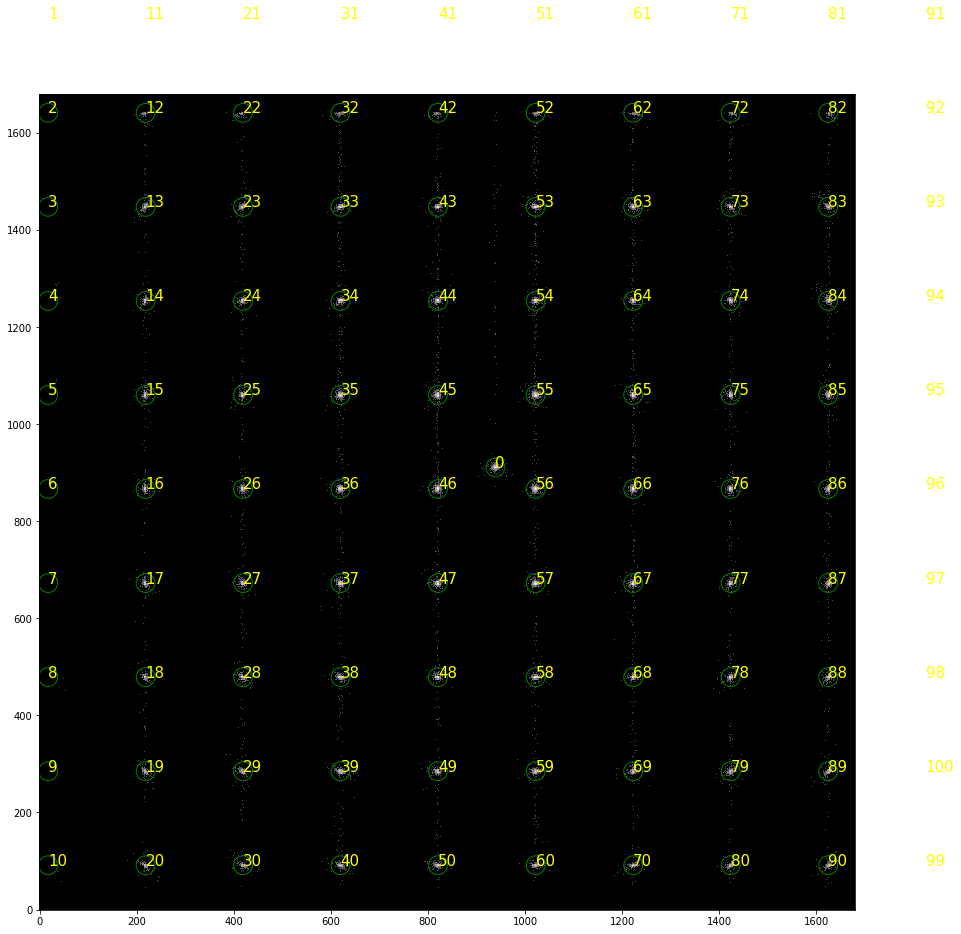

In [10]:
fig, ax = plt.subplots(figsize=(15,15))
#
norm1 = simple_norm(image1, 'log')
#norm2 = simple_norm(image2, 'log')
ax.imshow(image1, cmap='gray', interpolation='nearest', origin='lower',norm=norm1)
#ax[1].imshow(hdu2[0].data, cmap='gray', interpolation='nearest', origin='lower',norm=norm2)
#
for i,x in enumerate(reg):
    pix_reg1 = x.to_pixel(wcs1)
    #pix_reg2 = x.to_pixel(wcs2)
    pix_reg1.plot(ax=ax)
    ax.text(pix_reg1.center.x,pix_reg1.center.y,f'{i}',size=15,color='yellow')
    #pix_reg2.plot(ax=ax[1]

#
#plt.savefig(f'{wdir}/output_sources.png',dpi=100)
plt.show()
plt.close()

<Gaussian2D(amplitude=100., x_mean=3.05298915, y_mean=3.01885084, x_stddev=1.85144424, y_stddev=1.95186759, theta=-0.43235641)>

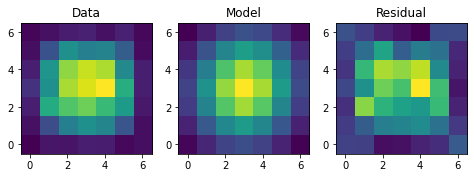

In [11]:
a = fit_source(image1,wcs1,reg[0],box=7)
a

In [12]:
centre = reg[0].center
#
sigma_x = []
sigma_y = []
off = []
counts = []
for i,x in enumerate(reg):
    #print (f'Doind source {i}')
    a = fit_source(image1,wcs1,x,box=7,plot_it=False,verbose=False)
    if (a is None):
        continue
    sigma_x.append(a.x_stddev.value)
    sigma_y.append(a.y_stddev.value)
    dist = centre.separation(x.center)
    off.append(dist.arcmin)
    #
    # now aperture photometry to measure th ecounts within radius
    #
    cs = measure_counts(image1,wcs1,x)
    counts.append(cs)

In [13]:
t = QTable((off,counts,np.sqrt(counts),sigma_x,sigma_y),names=['off','counts','counts_err','sig_x','sig_y'])
#t['offaxis'] = off
#t['counts'] = counts
#t['counts_err'] = np.sqrt(counts)
#t['sig_x'] = sigma_x
#t['sig_y'] = sigma_y
#
t.sort('off')
mask = t['counts'] > 0
t = t[mask]
t

off,counts,counts_err,sig_x,sig_y
float64,float64,float64,float64,float64
0.0,3313.9647006154783,57.56704526563334,1.8514442447235093,1.9518675936519425
1.574740486168536,3109.5584136112648,55.763414651644716,1.797706582712845,2.0399395524748365
2.1108350960481506,3014.9722960691442,54.90876338135056,2.008339519238773,1.7446609795444235
2.911939201230292,3058.130362654696,55.30036494142418,2.030400603687032,1.7292562958072324
3.2335225398964504,2794.143766884688,52.859661055333,2.2081066393585274,1.7079854548568045
4.324614456972896,2703.2604797068025,51.99288874170008,2.717178617921041,1.607401266635616
4.547268262763557,2547.786730174952,50.47560529775698,3.1041363012808443,1.688011085101396
4.773496581459148,2648.428059392403,51.46288040318384,1.8025151471628866,1.88130804833917
5.3551443832711865,2564.8228246977387,50.644079858338216,1.9868887520500902,4.1904828059794585


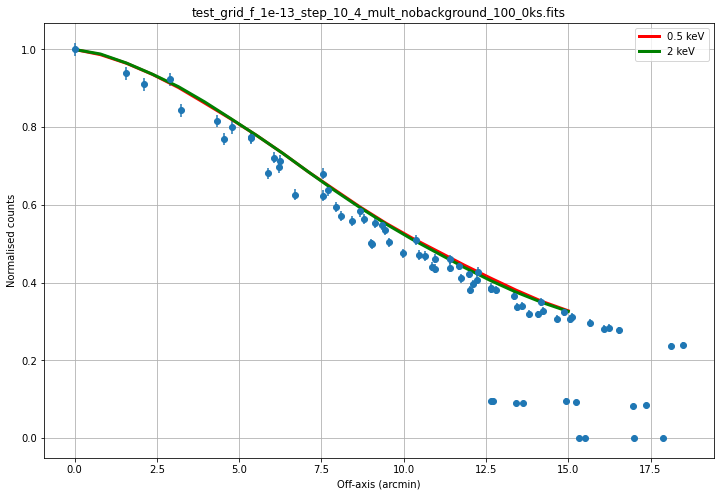

In [14]:
fig, ax = plt.subplots(figsize=(12,8))
#ax.scatter(off,amp/amp[0])
norm0 = t['counts'][0]
ax.errorbar(t['off'],t['counts']/norm0,yerr=t['counts_err']/norm0,fmt='o')
ax.plot(offs/60.0,xv1,color='red',lw=3,label='0.5 keV')
ax.plot(offs/60.0,xv2,color='green',lw=3,label='2 keV')
#ax.plot(xvig1,xv1['y'],color='red',lw=3,label='0.5 keV')
#ax.plot(xvig2,xv2['y'],color='green',lw=3,label='2 keV')
ax.set_xlabel('Off-axis (arcmin)')
ax.set_ylabel('Normalised counts')
ax.grid()
ax.legend()
plt.title(bname)
plt.savefig(f'{wdir}/check_vignetting_test_grid_f_1e-13_step_10_4_mult_nobackground_100_0ks.png',dpi=100)
plt.show()
plt.close();

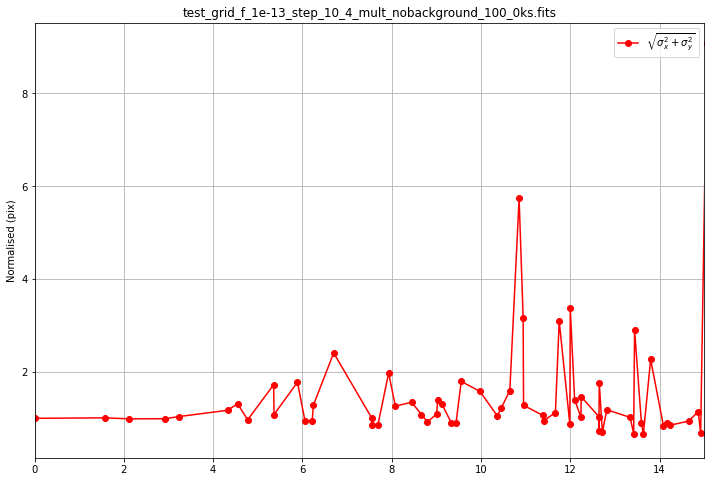

In [15]:
#
# plot sigmas
#
comb = np.sqrt(t['sig_x']**2 + t['sig_y']**2)
comb = comb/comb[0]
fig, ax = plt.subplots(figsize=(12,8))
#ax.scatter(off,amp/amp[0])
#ax.plot(t['off'],t['sig_x'],'bo-',label=r'$\sigma_x$')
#ax.plot(t['off'],t['sig_y'],'go-',label=r'$\sigma_y$')
#ax.plot(t['off'],t['sig_x']*t['sig_y'],'ro-',label=r'$\sigma_x \times \sigma_y$')
ax.plot(t['off'],comb,'ro-',label=r'$\sqrt{\sigma_x^2 + \sigma_y^2}$')

#ax.plot(xvig1,xv1['y'],color='red',lw=3,label='0.5 keV')
#ax.plot(xvig2,xv2['y'],color='green',lw=3,label='2 keV')
#ax.set_xlabel('Off-axis (arcmin)')
ax.set_ylabel('Normalised (pix)')
ax.set_xlim((0.0,15.0))
ax.grid()
ax.legend()
plt.title(bname)
plt.savefig(f'{wdir}/check_psf_test_grid_f_1e-13_step_10_4_mult_nobackground_100_0ks.png',dpi=100)
plt.show()
plt.close();